In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing as prep
import skimage.io
import pickle
from glob import glob
import pathlib
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import warnings
warnings.filterwarnings("ignore")

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1142850066612545573
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7772662462292286577
physical_device_desc: "device: XLA_CPU device"
]


In [3]:
#tf.device('cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dftr = pd.read_csv('/content/drive/MyDrive/fluent_speech_commands_dataset/data/train_data.csv',index_col=0)
dftr.head(1)

,path,speakerId,transcription,action,object,location
0,wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-1...,2BqVo8kVB2Skwgyb,Change language,change language,none,none


In [6]:
dfts = pd.read_csv('/content/drive/MyDrive/fluent_speech_commands_dataset/data/test_data.csv',index_col=0)
dfts.head(1)

,path,speakerId,transcription,action,object,location
0,wavs/speakers/4BrX8aDqK2cLZRYl/cbdf5700-452c-1...,4BrX8aDqK2cLZRYl,Turn on the lights,activate,lights,none


In [7]:
dfval = pd.read_csv('/content/drive/MyDrive/fluent_speech_commands_dataset/data/valid_data.csv',index_col=0)
dfval.head(1)

,path,speakerId,transcription,action,object,location
0,wavs/speakers/7NqqnAOPVVSKnxyv/8b863c90-4627-1...,7NqqnAOPVVSKnxyv,Turn on the lights,activate,lights,none


In [8]:
names=np.array(dftr['action']+' '+dftr['object']+' '+dftr['location'])
names=names.T
print(names.shape)
print(names[0:5])

(23132,)
['change language none none' 'activate music none' 'activate lights none'
 'activate lights none' 'deactivate lights none']


In [9]:
names_ts=np.array(dfts['action']+' '+dfts['object']+' '+dfts['location'])
names_ts=names_ts.T
print(names_ts.shape)
print(names_ts[0:5])

(3793,)
['activate lights none' 'deactivate lights none'
 'change language none none' 'deactivate music none' 'activate music none']


In [10]:
names_val=np.array(dfval['action']+' '+dfval['object']+' '+dfval['location'])
names_val=names_val.T
print(names_val.shape)
print(names_val[0:5])

(3118,)
['activate lights none' 'deactivate lights none'
 'change language none none' 'deactivate music none' 'activate music none']


In [11]:
le = prep.LabelEncoder()
ytr = le.fit_transform(names)
num_labels = np.max(ytr)+1
print(num_labels)
labels = le.classes_


31


In [12]:
yts = le.transform(names_ts)
yval = le.transform(names_val)

In [13]:
rand_sample = [15,43]
#print(labels)
print(names[rand_sample])
print(ytr[rand_sample])
print(labels[ytr[rand_sample]])

['deactivate music none' 'activate lights washroom']
[20  4]
['deactivate music none' 'activate lights washroom']


In [14]:
print(names_ts[rand_sample])
print(yts[rand_sample])
print(labels[yts[rand_sample]])

['increase volume none' 'activate lights kitchen']
[30  2]
['increase volume none' 'activate lights kitchen']


In [15]:
print(names_val[rand_sample])
print(yval[rand_sample])
print(labels[yval[rand_sample]])

['increase volume none' 'activate lights kitchen']
[30  2]
['increase volume none' 'activate lights kitchen']


In [16]:
Xtr_path = '/content/drive/MyDrive/fluent_speech_commands_dataset/'+dftr['path']
Xtr_path = tf.convert_to_tensor(Xtr_path)
print(Xtr_path.shape)
print(Xtr_path[0:5])

(23132,)
tf.Tensor(
[b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/2BqVo8kVB2Skwgyb/0a3129c0-4474-11e9-a9a5-5dbec3b8816a.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/2BqVo8kVB2Skwgyb/0ee42a80-4474-11e9-a9a5-5dbec3b8816a.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/2BqVo8kVB2Skwgyb/144d5be0-4474-11e9-a9a5-5dbec3b8816a.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/2BqVo8kVB2Skwgyb/1811b6e0-4474-11e9-a9a5-5dbec3b8816a.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/2BqVo8kVB2Skwgyb/1d9f3920-4474-11e9-a9a5-5dbec3b8816a.wav'], shape=(5,), dtype=string)


In [17]:
Xts_path = '/content/drive/MyDrive/fluent_speech_commands_dataset/'+dfts['path']
Xts_path = tf.convert_to_tensor(Xts_path)
print(Xts_path.shape)
print(Xts_path[0:5])

(3793,)
tf.Tensor(
[b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/4BrX8aDqK2cLZRYl/cbdf5700-452c-11e9-b1e4-e5985dca719e.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/4BrX8aDqK2cLZRYl/cff92500-452c-11e9-b1e4-e5985dca719e.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/4BrX8aDqK2cLZRYl/d36722a0-452c-11e9-b1e4-e5985dca719e.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/4BrX8aDqK2cLZRYl/d73086b0-452c-11e9-b1e4-e5985dca719e.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/4BrX8aDqK2cLZRYl/da54f830-452c-11e9-b1e4-e5985dca719e.wav'], shape=(5,), dtype=string)


In [18]:
Xval_path = '/content/drive/MyDrive/fluent_speech_commands_dataset/'+dfval['path']
Xval_path = tf.convert_to_tensor(Xval_path)
print(Xval_path.shape)
print(Xval_path[0:5])

(3118,)
tf.Tensor(
[b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/7NqqnAOPVVSKnxyv/8b863c90-4627-11e9-bc65-55b32b211b66.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/7NqqnAOPVVSKnxyv/8d8f7a10-4627-11e9-bc65-55b32b211b66.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/7NqqnAOPVVSKnxyv/8f7773f0-4627-11e9-bc65-55b32b211b66.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/7NqqnAOPVVSKnxyv/916cb440-4627-11e9-bc65-55b32b211b66.wav'
 b'/content/drive/MyDrive/fluent_speech_commands_dataset/wavs/speakers/7NqqnAOPVVSKnxyv/934321f0-4627-11e9-bc65-55b32b211b66.wav'], shape=(5,), dtype=string)


In [19]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [20]:
def get_waveform(file_path,labs):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform,labs

In [21]:
def get_spectrogram(waveform,lab):
  num_samples, sample_rate = int(16000*10), 16000.0
  # Padding for files with less than 16000*10 samples
  zero_padding = tf.zeros([num_samples] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=512, frame_step=256)

  spectrogram = tf.abs(spectrogram)

  #Convert Spectrogram to Mel-scale Spectrogram
  num_spectrogram_bins = spectrogram.shape[-1]
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 257
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
    upper_edge_hertz)
  mel_spectrogram = tf.tensordot(
    spectrogram, linear_to_mel_weight_matrix, 1)
  mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
  spectrograms = tf.convert_to_tensor((spectrogram, mel_spectrogram, log_mel_spectrogram))
  spectrograms = tf.transpose(spectrograms,perm=[1,2,0])
  return spectrograms, lab

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices((Xtr_path,ytr))
waveform_ds = files_ds.map(get_waveform, num_parallel_calls=AUTOTUNE)

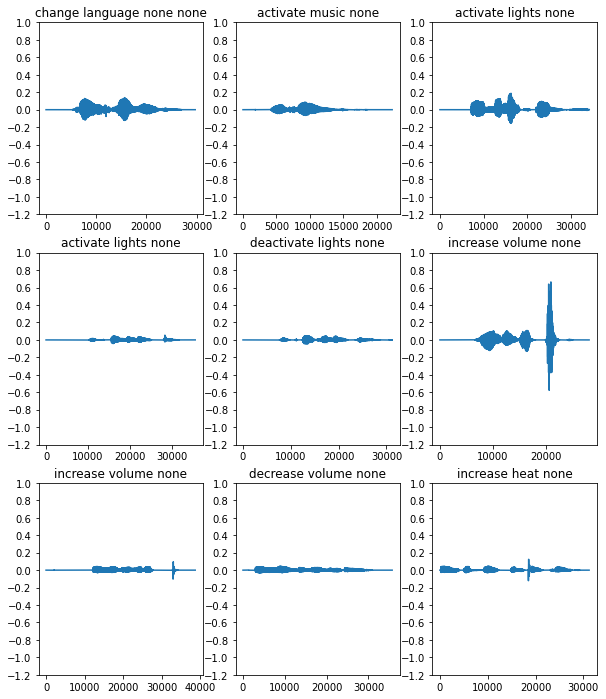

In [23]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio,cl) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  ax.set_title(labels[cl])

In [24]:
for waveform,cl in waveform_ds.take(1):
  spectrograms, label = get_spectrogram(waveform, cl)
spectrograms = tf.transpose(spectrograms,perm=[2,0,1])
print(spectrograms.shape)
print('Label:', labels[label])
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrograms[0].shape)
print('Mel Spectrogram shape:', spectrograms[1].shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

(3, 624, 257)
Label: change language none none
Waveform shape: (29722,)
Spectrogram shape: (624, 257)
Mel Spectrogram shape: (624, 257)
Audio playback


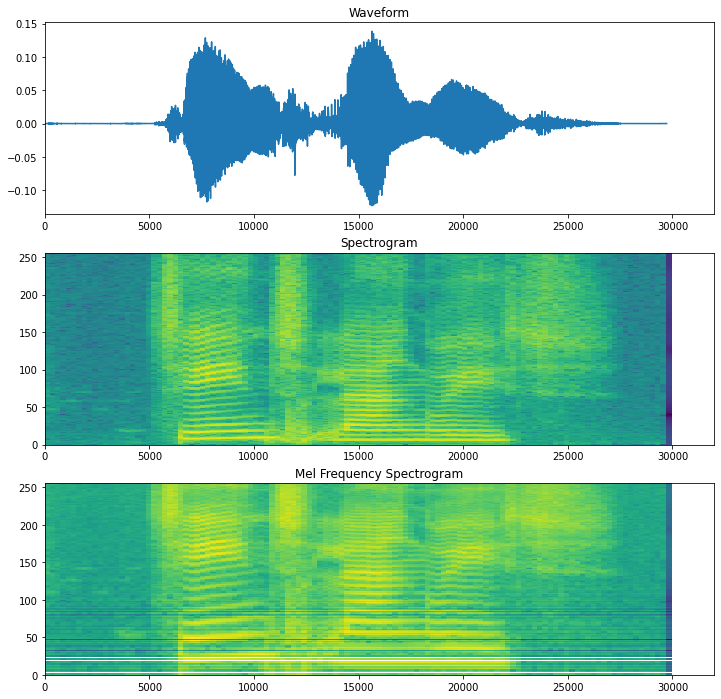

In [25]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(int(16000*10), step=height-1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(3, figsize=(12, 12))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000*2])
plot_spectrogram(spectrograms[0].numpy(), axes[1])
axes[1].set_title('Spectrogram')
axes[1].set_xlim([0, 16000*2])
plot_spectrogram(spectrograms[1].numpy(), axes[2])
axes[2].set_title('Mel Frequency Spectrogram')
axes[2].set_xlim([0, 16000*2])
plt.show()

In [26]:
spectrogram_ds = waveform_ds.map(get_spectrogram, num_parallel_calls=AUTOTUNE)
spectrogram_ds = spectrogram_ds.take(-1)

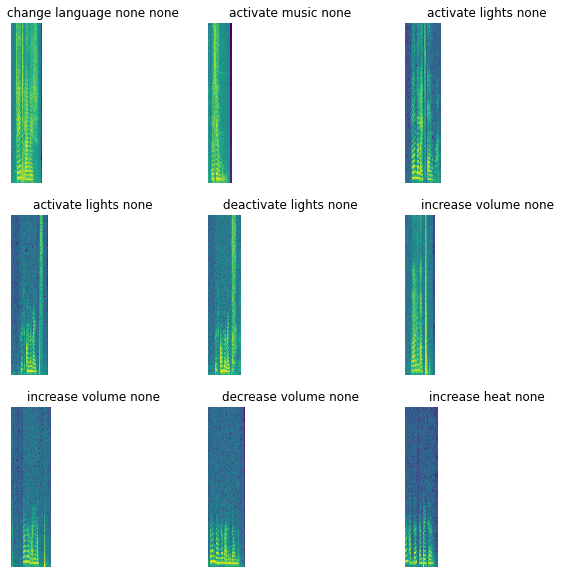

In [27]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram,label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  spectrogram = tf.transpose(spectrogram,perm=[2,0,1])
  plot_spectrogram(np.squeeze(spectrogram[0].numpy()), ax)
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')

plt.show()

In [28]:
print(labels)

['activate lamp none' 'activate lights bedroom' 'activate lights kitchen'
 'activate lights none' 'activate lights washroom' 'activate music none'
 'bring juice none' 'bring newspaper none' 'bring shoes none'
 'bring socks none' 'change language Chinese none'
 'change language English none' 'change language German none'
 'change language Korean none' 'change language none none'
 'deactivate lamp none' 'deactivate lights bedroom'
 'deactivate lights kitchen' 'deactivate lights none'
 'deactivate lights washroom' 'deactivate music none'
 'decrease heat bedroom' 'decrease heat kitchen' 'decrease heat none'
 'decrease heat washroom' 'decrease volume none' 'increase heat bedroom'
 'increase heat kitchen' 'increase heat none' 'increase heat washroom'
 'increase volume none']


In [29]:
root_path = '/content/drive/MyDrive/fluent_speech_commands_dataset/'
dir_name = ['train','test','val']
keywords = labels
os.chdir(root_path)
for direc in dir_name:
  for key in keywords:
    filename = direc+ '/' + key
    if not os.path.isdir(direc):
      os.mkdir(direc)
      print(f"Creating directory {direc}")
    if not os.path.isdir(filename):
      os.mkdir(filename)
      print(f"Creating sub-directory {filename}")
    else:
      print(f"Images will be stored in directory {filename}" )


Images will be stored in directory train/activate lamp none
Images will be stored in directory train/activate lights bedroom
Images will be stored in directory train/activate lights kitchen
Images will be stored in directory train/activate lights none
Images will be stored in directory train/activate lights washroom
Images will be stored in directory train/activate music none
Images will be stored in directory train/bring juice none
Images will be stored in directory train/bring newspaper none
Images will be stored in directory train/bring shoes none
Images will be stored in directory train/bring socks none
Images will be stored in directory train/change language Chinese none
Images will be stored in directory train/change language English none
Images will be stored in directory train/change language German none
Images will be stored in directory train/change language Korean none
Images will be stored in directory train/change language none none
Images will be stored in directory train

In [30]:
from tqdm import tqdm

def preprocess_dataset(files,direc,itype=None):
  if itype == None:
    itype = '.png'
  p = tqdm(total=files[0].shape[0], disable=False, position=0, leave=True)
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  for i,(path,lab) in enumerate(files_ds):
    ilab = labels[lab]
    inum = i
    iname = '/{:s}_{:05d}'.format(ilab,inum)
    iname = direc+'/'+ ilab + iname + itype
    if len(glob(iname)) == 0:
      wavey,lab = get_waveform(path,lab)
      if (wavey.shape[0]) <= (16000*10): #(Samplong_Freq*Duration)
        specy,lab = get_spectrogram(wavey,lab)
        skimage.io.imsave(iname, specy.numpy())
    else:
      print('Found')
    p.update(1)
    if (i%100)==0:
      display.clear_output()
  return 


#Please disable **Preprocess** variable below if data has already been processed.

In [31]:
Preprocess = False

.


.

In [32]:
if Preprocess:
  preprocess_dataset((Xtr_path,ytr),'train')

In [33]:
if Preprocess:
  preprocess_dataset((Xts_path,yts),'test')

In [34]:
if Preprocess:
  preprocess_dataset((Xval_path,yval),'val')

In [35]:
def spec_only(spec,lab):
  
  return spec

for spec, lab in spectrogram_ds.take(1):
  spectrograms = spec_only(spec,lab)
  input_shape = spectrograms.shape
print('Input shape:', input_shape)
print(len(labels))
nrow = input_shape[0]
ncol = input_shape[1]
print(nrow)
print(ncol)



Input shape: (624, 257, 3)
31
624
257


In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 50 #map function used to create train_ds overflows
train_data_dir = './train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.0,
                                   horizontal_flip=False)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        classes=labels.tolist(),
                        class_mode= 'sparse')

Found 23130 images belonging to 31 classes.


In [37]:
test_data_dir = './test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.0,
                                   horizontal_flip=False)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        classes=labels.tolist(),
                        class_mode='sparse')

Found 3793 images belonging to 31 classes.


In [38]:
val_data_dir = './val'
val_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.0,
                                   horizontal_flip=False)
val_generator = val_datagen.flow_from_directory(
                        val_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        classes=labels.tolist(),
                        class_mode='sparse')

Found 3118 images belonging to 31 classes.


In [89]:
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense,Conv2D, MaxPooling2D, Input, BatchNormalization

In [40]:
import tensorflow.keras.backend as K
K.clear_session()

In [41]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import decode_predictions, preprocess_input  
base_model = applications.VGG19(include_top=False, weights='imagenet', input_shape = input_shape)

80142336/80134624 [==============================] - 1s 0us/step


In [92]:
model = Sequential()
use_base_model = True

In [93]:
#Loop over base_model.layers and add each layer to model
if use_base_model:
  for layer in base_model.layers:
    model.add(layer)

  for layer in model.layers:
    layer.trainable = False
  model.add(BatchNormalization())
else:
  model.add(Input(shape=input_shape))

In [94]:
model.add(Conv2D(256, 3, activation='relu'))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))


In [71]:
#model.get_layer('block5_conv2').trainable=True
#model.get_layer('block5_conv3').trainable=True
#model.get_layer('block5_conv4').trainable=True

In [95]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 624, 257, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 624, 257, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 312, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 312, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 312, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 156, 64, 128)      0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 156, 64, 256)    

In [82]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [83]:
steps_per_epoch = Xtr_path.shape[0]//batch_size
validation_steps = Xval_path.shape[0]//batch_size
print(f'Steps per epoch = {steps_per_epoch}')
print(f'Validadtion Steps = {validation_steps}')

Steps per epoch = 462
Validadtion Steps = 62


In [84]:
EPOCHS = 10
history = model.fit_generator(
    train_generator, 
    validation_data=val_generator,  
    validation_steps=validation_steps,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
  5/462 [..............................] - ETA: 10:08:07 - loss: 3.9160 - accuracy: 0.0560

KeyboardInterrupt: ignored

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()